In [2]:
import pickle
import pandas as pd
import urllib.request
import os
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"

# download data
if not os.path.isfile("data.csv"):
    urllib.request.urlretrieve(data_url, "data.csv")

"""
Use the store_object function to make local caching of the data.
"""
def store_object(filename, instruction):
    # check if file was cached before and read it
    if os.path.isfile(filename):
        return pickle.load(open(filename, 'rb'))
    # run instruction and save it as pickle then return object
    else:
        obj = instruction()
        pickle.dump(obj, open(filename, 'wb'))
        return obj
    
data = store_object("data.pkl", lambda: pd.read_csv("data.csv"))
data = data[["Crm Cd", "Mocodes", "Crm Cd Desc", "AREA NAME"]]
data.head(5)

,Crm Cd,Mocodes,Crm Cd Desc,AREA NAME
0,510,NaN,VEHICLE - STOLEN,Wilshire
1,330,1822 1402 0344,BURGLARY FROM VEHICLE,Central
2,480,0344 1251,BIKE - STOLEN,Southwest
3,343,0325 1501,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),Van Nuys
4,354,1822 1501 0930 2004,THEFT OF IDENTITY,Hollywood


In [6]:
# 20 most common crimes
most_comma_crimes = data["Crm Cd"].value_counts()[:20]
most_comma_crimes_names = data["Crm Cd Desc"].value_counts()[:20]
rows_to_drop = []
ć = {}
for idx, crime in enumerate(data["Crm Cd"]):
    if crime not in most_comma_crimes:
        rows_to_drop.append(idx)
# remove rows that are not 20 most comma crimes   
print(most_comma_crimes_names)
print(most_comma_crimes)
data.drop(rows_to_drop, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
crime_code_to_desc = data.drop_duplicates(subset="Crm Cd")[["Crm Cd", "Crm Cd Desc"]].set_index("Crm Cd")["Crm Cd Desc"]

# Create the dictionary with crime codes as keys and descriptions as values
crime_dict = {code: crime_code_to_desc[code] for code in most_comma_crimes.index}

Crm Cd Desc
VEHICLE - STOLEN                                            96751
BATTERY - SIMPLE ASSAULT                                    71648
THEFT OF IDENTITY                                           55739
BURGLARY FROM VEHICLE                                       55598
BURGLARY                                                    55206
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     54671
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              51319
THEFT PLAIN - PETTY ($950 & UNDER)                          45996
INTIMATE PARTNER - SIMPLE ASSAULT                           44910
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             34639
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         32226
ROBBERY                                                     30815
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    29936
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                    23486
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    2299

In [11]:
mocodes_count = {}
rows_to_drop = [] # remove row id there is no mocode
for idx, mocodes in enumerate(data['Mocodes']):
    if pd.isna(mocodes):
        rows_to_drop.append(idx)
        continue
    mocodes = str(mocodes).split(" ")
    for mocode in mocodes:
        if mocode in mocodes_count:
            mocodes_count[mocode] += 1
        else:
            mocodes_count[mocode] = 1
# remove rows with no mocodes
data.drop(rows_to_drop, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True) 

In [28]:
import csv
# take 50 mocodes that are most comman
sorted_mocodes = dict(sorted(mocodes_count.items(), key=lambda x: x[1], reverse=True))
top_50 = dict(list(sorted_mocodes.items())[:70])
print("50 najczesciej wystepujacych mocode")
print(top_50)

# Słownik na wybrane kody
selected_codes = {}

# Wczytanie pliku CSV
with open('mo_codes.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file, delimiter=';')
    for row in reader:
        code = row['code']
        info = row['info']
        if code in top_50:
            selected_codes[code] = info

# Wyświetlenie wyniku
print(selected_codes)

# add column for 50 mocodes
for mocode in top_50:
    data[mocode] = 0
# set flag 1 if mocode occure
for idx, mocodes in enumerate(data["Mocodes"]):
    mocodes = str(mocodes).split(" ")
    for mocode in mocodes:
        if mocode in top_50.keys():
            data.at[idx, mocode] = 1
data.drop(["Mocodes", "Crm Cd Desc"], axis=1, inplace=True)
df = data
df.head(3)

50 najczesciej wystepujacych mocode
{'1822': 263902, '0344': 242100, '0913': 120824, '0329': 112070, '0416': 108068, '1300': 78999, '2000': 66285, '0400': 61669, '1402': 42215, '2004': 41758, '1814': 40891, '1609': 37132, '0334': 36485, '1309': 32944, '0444': 32835, '1202': 31840, '0325': 31075, '1307': 29839, '0446': 25186, '0385': 22627, '0421': 21817, '0432': 21245, '1813': 20268, '1501': 20066, '0342': 19937, '0100': 19670, '0321': 19512, '0448': 18558, '1218': 18545, '0429': 18533, '1606': 17384, '0358': 17092, '0930': 16811, '0352': 16322, '0394': 14207, '0377': 14036, '0216': 13775, '1607': 13738, '0443': 13312, '0302': 13148, '1414': 12519, '0906': 12266, '0417': 12202, '2038': 12063, '0922': 11484, '0447': 11458, '1601': 11368, '0445': 11283, '1420': 11190, '0910': 10616, '0408': 10040, '0603': 9397, '1310': 9280, '0361': 8963, '2032': 8582, '0319': 7724, '0929': 7626, '1602': 7607, '0202': 7568, '1100': 7419, '0602': 7228, '0411': 7202, '2002': 7110, '0419': 7073, '1817': 674

KeyError: 'Mocodes'

In [13]:
X = df.iloc[:, 1:]
y = df["Crm Cd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [14]:
from sklearn.preprocessing import LabelEncoder
X_train = pd.get_dummies(X_train, columns=['AREA NAME'])
X_test = pd.get_dummies(X_test, columns=['AREA NAME'])
#df_encoded

In [15]:
# If there is no model - train MLP
if not os.path.exists("./models/classification_models/mlp_70mocodes_area.pkl"):
    # Train using Grid search
    mlp_model = MLPClassifier(max_iter=300, hidden_layer_sizes=(72, 72), learning_rate='adaptive', solver='adam', activation='relu', alpha=0.0001)
    mlp_model.fit(X_train, y_train)
    # param_grid = {
    #     'hidden_layer_sizes': [(52,), (52,52), (100,100)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['sgd', 'adam'],
    #     'alpha': [0.0001, 0.001,],
    #     'learning_rate': ['constant', 'adaptive'],
    # }
    # grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
    # grid_search.fit(X_train, y_train)
    # print("Best parameters found: ", grid_search.best_params_)
    # mlp_model = grid_search.best_estimator_
    
    
    with open('models/classification_models/mlp_70mocodes_area.pkl','wb') as f:
        pickle.dump(mlp_model,f)
# Load model if exist
else:
    with open('models/classification_models/mlp_70mocodes_area.pkl', 'rb') as f:
        mlp_model = pickle.load(f)
        
        
# Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (52, 52), 'learning_rate': 'adaptive', 'solver': 'adam'}

In [8]:
# If there is no model - train MNB
if not os.path.exists("./models/classification_models/mnb_50mocodes.pkl"):
    multinomial_nb = MultinomialNB()
    param_grid_multinomial = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
    }
    grid_search_multinomial = GridSearchCV(estimator=multinomial_nb, param_grid=param_grid_multinomial, n_jobs=-1, cv=3, verbose=2)
    grid_search_multinomial.fit(X_train, y_train)
    mnb_model = grid_search_multinomial.best_estimator_
    
    with open('models/classification_models/mnb_50mocodes.pkl', 'wb') as f:
        pickle.dump(mnb_model, f)
# Load model if exist
else:
    with open('models/classification_models/mnb_50mocodes.pkl', 'rb') as f:
        mnb_model = pickle.load(f)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [9]:
# If there is no model - train RF
if not os.path.exists("./models/classification_models/rf_50mocodes.pkl"):
    rf_model = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=100)
    rf_model.fit(X_train, y_train)
    # param_grid = {
    # 'n_estimators': [50, 100],
    # 'max_depth': [None, 15, 25, 35],
    # 'min_samples_split': [2, 5],
    # 'min_samples_leaf': [2, 4],
    # 'max_features': ['auto', 'sqrt']
    # }
    # grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
    # grid_search.fit(X_train, y_train)
    # rf_model = grid_search.best_estimator_
    # print("Best parameters found: ", grid_search.best_params_)
    # {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
    with open('models/classification_models/rf_50mocodes.pkl','wb') as f:
        pickle.dump(rf_model,f)
# Load model if exist
else:
    with open('models/classification_models/rf_50mocodes.pkl', 'rb') as f:
        rf_model = pickle.load(f)

In [12]:
#with open('models/classification_models/rf_70mocodes_area.pkl', 'rb') as f:
#         rf_model70area = pickle.load(f)
# with open('models/classification_models/rf_70mocodes.pkl', 'rb') as f:
#          rf_model70 = pickle.load(f)
with open('models/classification_models/rf_50mocodes.pkl', 'rb') as f:
         rf_model50area = pickle.load(f)
#         
#with open('models/classification_models/mlp_70mocodes_area.pkl', 'rb') as f:
#        mlp_model70area = pickle.load(f)
# with open('models/classification_models/mlp_70mocodes.pkl', 'rb') as f:
#          mlp_model70 = pickle.load(f)
with open('models/classification_models/mlp_50mocodes.pkl', 'rb') as f:
         mlp_model50area = pickle.load(f)
#         
#with open('models/classification_models/mnb_70mocodes_area.pkl', 'rb') as f:
#         mnb_model70area = pickle.load(f)
# with open('models/classification_models/mnb_70mocodes.pkl', 'rb') as f:
#          mnb_model70 = pickle.load(f)
with open('models/classification_models/mnb_50mocodes.pkl', 'rb') as f:
         mnb_model50area = pickle.load(f)

#preds_rf_model70area = rf_model70area.predict(X_test)
#preds_rf_model70 = rf_model70.predict(X_test)
preds_rf_model50 = rf_model50area.predict(X_test)

#preds_mlp_model70area = mlp_model70area.predict(X_test)
#preds_mlp_model70 = mlp_model70.predict(X_test)
preds_mlp_model50 = mlp_model50area.predict(X_test)

#preds_mnb_model70area = mnb_model70area.predict(X_test)
#preds_mnb_model70 = mnb_model70.predict(X_test)
preds_mnb_model50 = mnb_model50area.predict(X_test)

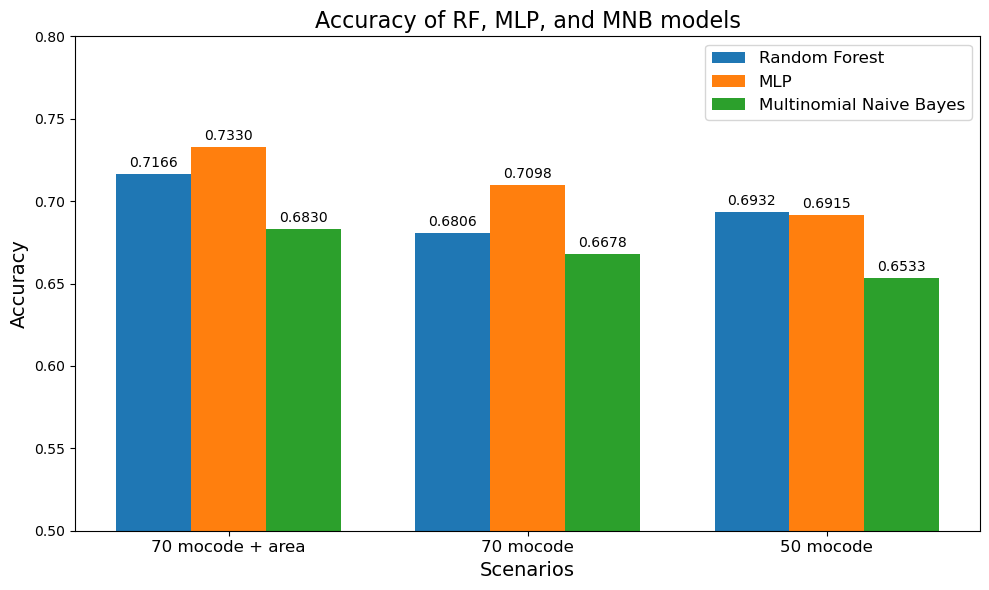

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Wyniki predykcji
# Precyzje dla kolejno 70mocode + area, 70 mocode, 50 mocode
acc_rf = [0.7166, 0.6806, 0.6932]
acc_mlp = [0.7330, 0.7098, 0.6915]
acc_mnb = [0.6830, 0.6678, 0.6533]

# Labels for the scenarios
scenarios = ['70 mocode + area', '70 mocode', '50 mocode']
n_scenarios = len(scenarios)
n_models = 3

# Bar width and positions
bar_width = 0.25
index = np.arange(n_scenarios)

# Plotting the bars with larger figure size
fig, ax = plt.subplots(figsize=(10, 6))
bars_rf = ax.bar(index, acc_rf, bar_width, label='Random Forest')
bars_mlp = ax.bar(index + bar_width, acc_mlp, bar_width, label='MLP')
bars_mnb = ax.bar(index + 2 * bar_width, acc_mnb, bar_width, label='Multinomial Naive Bayes')

# Adding numerical labels to each bar
for bars in [bars_rf, bars_mlp, bars_mnb]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding labels and title
ax.set_xlabel('Scenarios', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy of RF, MLP, and MNB models', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(scenarios, fontsize=12)
ax.set_ylim(0.5, 0.8)
ax.legend(fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.show()


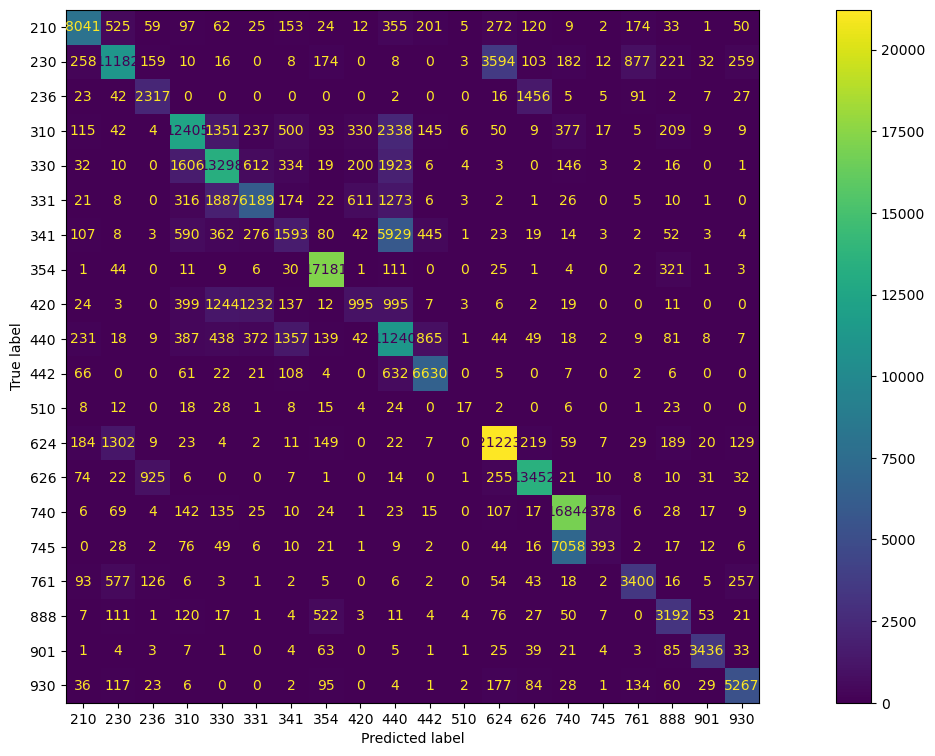

In [47]:
preds = mlp_model.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(
y_test, preds, ) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(9) 

In [49]:
X_test.iloc[0]

1822                         1
0344                         0
0913                         0
0329                         0
0416                         0
                         ...  
AREA NAME_Topanga        False
AREA NAME_Van Nuys       False
AREA NAME_West LA        False
AREA NAME_West Valley    False
AREA NAME_Wilshire       False
Name: 534785, Length: 91, dtype: object

In [40]:
# Tworzenie wektora wejściowego
import numpy as np


# Ofiara znala podejrzanego + wycelowana bron:
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['0913'] = 1 # ofiara znala podejrzanego
input_vector['0302'] = 1 # wycelowana bron
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
0.9213988585795363


In [39]:
# tylko wycelowana bron:
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['0302'] = 1 # wycelowana bron
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
0.5703759565355788


In [42]:
# wtargniecie siłą + grozenie smiercia
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['0358'] = 1
input_vector['0421'] = 1
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

CRIMINAL THREATS - NO WEAPON DISPLAYED
0.9928606991454237


In [29]:
selected_codes

{'0100': 'Suspect Impersonate',
 '0104': 'Customer',
 '0202': 'Cap/hat',
 '0216': 'Suspect wore hood/hoodie',
 '0302': 'Aimed gun',
 '0319': 'Profanity Used',
 '0321': 'Ransacked',
 '0325': 'Took merchandise',
 '0329': 'Vandalized',
 '0334': 'Brandishes weapon',
 '0342': 'Multi-susps overwhelm',
 '0344': 'Removes vict property',
 '0352': "Took Victim's clothing or jewelry",
 '0358': 'Forces Entry',
 '0361': 'Suspect is neighbor',
 '0377': "Takes vict's identification/driver license",
 '0385': 'Suspect removed parts from vehicle',
 '0394': 'Susp takes UPS, Fedex, USPS packages',
 '0400': 'Force used',
 '0408': 'Choked/uses choke hold/Strangulation',
 '0411': 'Cut/stabbed',
 '0416': 'Hit-Hit w/ weapon',
 '0417': 'Kicked',
 '0419': 'Pulled victims hair',
 '0421': 'Threaten to kill',
 '0429': 'Vict knocked to ground',
 '0432': 'Intimidation',
 '0443': 'Threaten to harm victim (other than kill)',
 '0444': 'Pushed',
 '0445': 'Suspect swung weapon',
 '0446': 'Suspect swung fist',
 '0447': 'Su

In [46]:
# Ofiara pozostawila mienie bez opieki:
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['2032'] = 1
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

THEFT PLAIN - PETTY ($950 & UNDER)
0.6260462814398022


In [54]:
# strzaly -> 0.76 na zabojstwo
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['1100'] = 1
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
0.7647165891476515


In [59]:
# osoba po 60 lub niepelnosprawna - kradziez dokumentu
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['1202'] = 1
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

THEFT OF IDENTITY
0.35609043902261583


In [64]:
# ofiara byla studentem - "zwykla napaść"
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['1251'] = 1
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

BATTERY - SIMPLE ASSAULT
0.5322407841707755


In [67]:
# Rodzina + pijany, zwykla napaść
input_vector = pd.DataFrame(np.zeros((1, 91)), columns=X_train.columns)
input_vector['2002'] = 1
input_vector['0602'] = 1
print(crime_dict[int(mlp_model.predict(input_vector))])
prob_matrix = mlp_model.predict_proba(input_vector)
print(np.max(prob_matrix))

BATTERY - SIMPLE ASSAULT
0.7507527583414052


VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
0.632471180818568
